In [139]:
import numpy as np
from eden import graph
from sklearn.decomposition import TruncatedSVD

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import matplotlib
import umap
import utilities

from evaluator import Evaluator
from sklearn.neighbors import KNeighborsClassifier
import sklearn as sk
from sklearn.model_selection import train_test_split


# Load dataset 624249 

In [140]:
import networkx as nx
def load_generated_data_classification(path):
    
    graphs = nx.read_gpickle(path+'/'+'graphs.gpickle')
    labels = list(np.load(path+'/'+'labels.npy'))
    
    return (graphs,labels)

def sub_sample_classification(graphs,labels, n_graphs):
    
    graphs, labels = sk.utils.shuffle(graphs, labels)
        
    return (graphs[0:n_graphs],labels[0:n_graphs])

In [141]:
graphs, labels = load_generated_data_classification("generate_graphs/624249_pos_neg")

In [142]:
#graphs, labels = sub_sample_classification(graphs,labels,1000)

In [143]:
# prepross 
for g in graphs:
    for node in g.nodes():
        g.nodes[node]['vec'] = []
for g in graphs:
    for edge in g.edges():
        g.edges[edge]['vec'] = []

In [144]:
graphs_train,graphs_test,labels_train,labels_test = train_test_split(graphs,labels,test_size=0.3)

In [145]:
print(len(graphs_train))

274


In [146]:
vectoriz = graph.Vectorizer(complexity = 5)
data_train = vectoriz.transform(graphs_train)
data_test = vectoriz.transform(graphs_test)

# MODEL1: Vect PCA_500 UMAP_2

In [147]:
pca_1 = TruncatedSVD(n_components=500)
m1_200_data_train = pca_1.fit(data_train).transform(data_train)
m1_200_data_test = pca_1.transform(data_test)

In [148]:
uma = umap.UMAP(n_components=2)
res_m1_train = uma.fit(m1_200_data_train,labels_train).transform(m1_200_data_train)
res_m1_test = uma.transform(m1_200_data_test)

		 +++++ ORIGINAL SPACE +++++


/home/antonio/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/antonio/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


K.N.N.  acc:  0.7346153846153847

		 +++++ TEST +++++
K.N.N.  acc:  0.6252913752913751

		 +++++ TRAIN +++++
K.N.N.  acc:  1.0


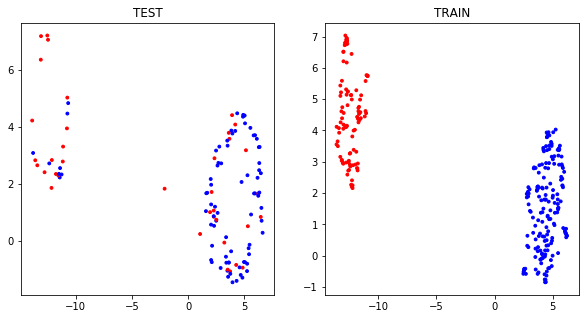

In [149]:
print("\t\t +++++ ORIGINAL SPACE +++++")
eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
acc,_,_,_ = eva.performance_with_kfold(data_test,labels_test)
print("K.N.N.  acc: ",np.mean(acc))


plot_embedding(res_m1_test,labels_test,res_m1_train,labels_train)

# MODEL2: Vect -- PCA_500 -- AUTOENCODER_60 -- UMAP 2

In [150]:
from keras import Input
from keras.layers import Dense, Dropout
from keras import Model
from keras.initializers import RandomNormal
from keras.losses import mean_squared_error

from keras.callbacks import EarlyStopping, TensorBoard

In [151]:
pca_2 = TruncatedSVD(n_components=500)
m2_200_data_train = pca_2.fit(data_train).transform(data_train)
m2_200_data_test = pca_2.transform(data_test)

#### scaler

In [152]:
from embedder import Preprocessing_scaler
scaler = Preprocessing_scaler([0, 1])
m2_200_scal_data_train = scaler.fit(m2_200_data_train).transform(m2_200_data_train)
m2_200_scal_data_test = scaler.transform(m2_200_data_test)

#### normalizer

In [153]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(copy=True, norm='l2')  
m2_200_norm_data_train = normalizer.fit(m2_200_scal_data_train).transform(m2_200_scal_data_train)
m2_200_norm_data_test = normalizer.transform(m2_200_scal_data_test)

In [154]:
input_auto = len(m2_200_scal_data_train[0])
print(input_auto)

274


##### define autoencoder

In [155]:
iniz = RandomNormal(mean=0, stddev=0.05)

rate_drop = 0.8

x_in = Input(shape=(input_auto,))
enc = Dense(input_auto * 2, activation="relu",kernel_initializer=iniz)(x_in)
enc = Dropout(rate = rate_drop)(enc)
enc = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)
enc = Dropout(rate = 0.5)(enc)
enc = Dense(60, activation="sigmoid",kernel_initializer=iniz)(enc)

dec = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)

autoencoder = Model(x_in, dec)
autoencoder.compile(optimizer='adam', loss=mean_squared_error)

In [156]:
path = "logs_sintetici/sintetici_107000" 
tb = TensorBoard(log_dir=path)
er = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)


autoencoder.fit(m2_200_norm_data_train,m2_200_norm_data_train,
                epochs=2500,
                verbose = 0,
                batch_size = 32,
                validation_split = 0.2,
                callbacks=[tb,er])

print(autoencoder.evaluate(m2_200_norm_data_test,m2_200_norm_data_test))

118/118 [==============================] - 0s 251us/step
0.0016352328771756868


In [157]:
print(er.stopped_epoch)

216


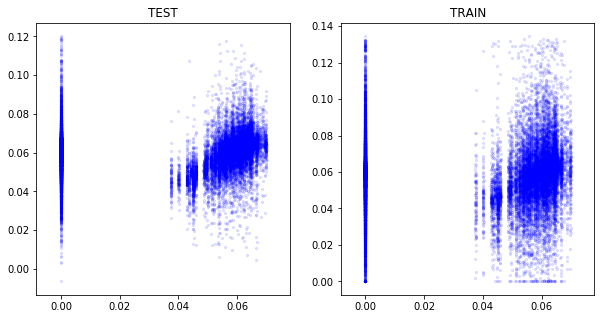

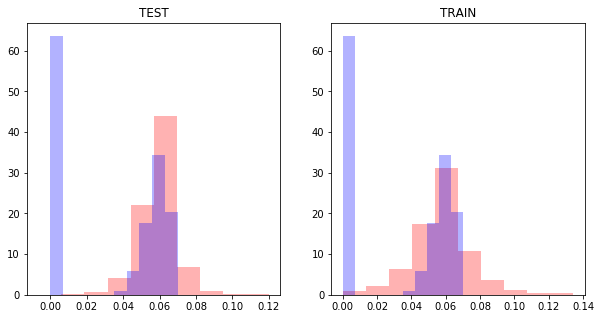

In [158]:
pred_test = autoencoder.predict(m2_200_norm_data_test)
pred_train = autoencoder.predict(m2_200_norm_data_test)

plot_auto(pred_test,pred_train,m2_200_norm_data_test,m2_200_norm_data_train)

In [159]:
encoder_1 = Model(x_in, enc)
res_auto_train = encoder_1.predict(m2_200_norm_data_train)

uma_2 = umap.UMAP(n_components=2)
res_m2_train = uma_2.fit(res_auto_train,labels_train).transform(res_auto_train)

res_auto_test = encoder_1.predict(m2_200_norm_data_test)
res_m2_test = uma_2.transform(res_auto_test)


		 +++++ TEST +++++
K.N.N.  acc:  0.5735431235431234

		 +++++ TRAIN +++++
K.N.N.  acc:  1.0


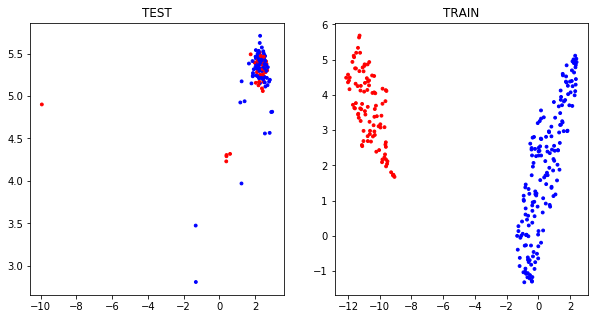

In [160]:
plot_embedding(res_m2_test,labels_test,res_m2_train,labels_train)

# MODEL3: Vect -- PCA_500 -- SUPERVISED_AUTOENCODER_60 -- UMAP 2
## 2 ITERATIONS

In [161]:
pca_3 = TruncatedSVD(n_components=500)
m3_200_data_train = pca_3.fit(data_train).transform(data_train)
m3_200_data_test = pca_3.transform(data_test)

# SCALER
scaler_3 = Preprocessing_scaler([0, 1])
m3_200_scal_data_train = scaler_3.fit(m2_200_data_train).transform(m3_200_data_train)
m3_200_scal_data_test = scaler_3.transform(m3_200_data_test)

# NORMALIZER
normalizer_3 = Normalizer(copy=True, norm='l2')  
m3_200_norm_data_train = normalizer_3.fit(m2_200_scal_data_train).transform(m3_200_scal_data_train)
m3_200_norm_data_test = normalizer_3.transform(m3_200_scal_data_test)

input_auto = len(m2_200_scal_data_train[0])

##### define autoencoder

In [162]:
iniz = RandomNormal(mean=0, stddev=0.05)

prob_drop = 0.5
x_in = Input(shape=(input_auto,))
enc = Dense(input_auto*2, activation="relu",kernel_initializer=iniz)(x_in)
enc = Dropout(prob_drop)(enc)
enc = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)
enc = Dense(60, activation="sigmoid",kernel_initializer=iniz)(enc)

decode = Dense(input_auto, activation="relu",name='decoder',kernel_initializer=iniz)(enc)

cla = Dense(10, activation='relu',name='cla_10')(enc)
cla = Dense(2, activation='softmax',name='classifier')(cla)


sup_autoencoder = Model(inputs = x_in, outputs = [decode,cla])

sup_autoencoder.compile(optimizer='adam',
                    metrics={'decoder': 'mse', 'classifier': ['acc']},
                    loss = {'decoder': 'mean_squared_error', 'classifier': 'categorical_crossentropy'},
                    loss_weights = {'decoder': 0.1, 'classifier': 0.00001})

In [163]:
er = EarlyStopping(monitor='val_classifier_acc', patience=80, restore_best_weights=True)

sup_autoencoder.fit(m3_200_norm_data_train,
                    {'decoder': m3_200_norm_data_train, 'classifier': utilities.from_np_to_one_hot(labels_train)},
                    epochs=500,    
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[er])

a = sup_autoencoder.evaluate(m3_200_norm_data_test,[m3_200_norm_data_test,utilities.from_np_to_one_hot(labels_test)])
n = sup_autoencoder.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

118/118 [==============================] - 0s 277us/step
loss 0.0002370309306632222
decoder_loss 0.0023050526535864603
classifier_loss 0.6525657732607955
decoder_mean_squared_error 0.0023050526535864603
classifier_acc 0.6864406769558534


### second iteration

In [164]:
sup_autoencoder_w = sup_autoencoder.get_weights()

In [165]:
iniz = RandomNormal(mean=0, stddev=0.05)

prob_drop = 0.5

x_in = Input(shape=(input_auto,))
enc = Dense(input_auto*2, activation="relu",kernel_initializer=iniz)(x_in)
enc = Dropout(prob_drop)(enc)
enc = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)
enc = Dense(60, activation="sigmoid",kernel_initializer=iniz)(enc)


decode = Dense(input_auto, activation="relu",name='decoder',kernel_initializer=iniz)(enc)

cla = Dense(10,trainable=False, activation='relu',name='cla')(enc)
cla = Dense(2,trainable=False, activation='softmax',name='classifier')(cla)


sup_autoencoder_2 = Model(inputs = x_in, outputs = [decode,cla])

sup_autoencoder_2.compile(optimizer='adam',
                      metrics={'decoder': 'mse', 'classifier': ['acc']},
                      loss = {'decoder': 'mean_squared_error', 'classifier': 'categorical_crossentropy'},
                      loss_weights = {'decoder': 0.1, 'classifier': 0.000001})

sup_autoencoder_2.set_weights(sup_autoencoder_w)


In [166]:
path = "logs_sintetici/sintetici_mix_2_10001" 
tb = TensorBoard(log_dir=path)

sup_autoencoder_2.fit(m3_200_norm_data_train,
                      {'decoder': m3_200_norm_data_train, 'classifier': utilities.from_np_to_one_hot(labels_train)},
                      epochs=1000,    
                      verbose=0,
                      validation_split=0.2,
                      callbacks=[tb])

a = sup_autoencoder_2.evaluate(m3_200_norm_data_test,[m3_200_norm_data_test,utilities.from_np_to_one_hot(labels_test)])
n = sup_autoencoder_2.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

118/118 [==============================] - 0s 259us/step
loss 0.00019700404244743413
decoder_loss 0.0019636986208921773
classifier_loss 0.6341807044158547
decoder_mean_squared_error 0.0019636986208921773
classifier_acc 0.6864406769558534


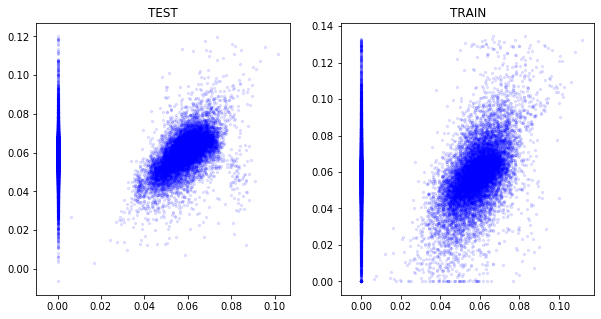

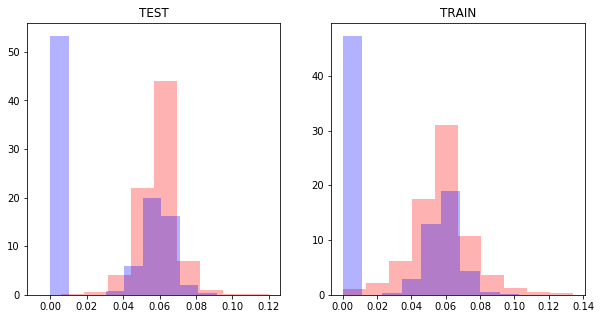

In [167]:
pred_test = sup_autoencoder_2.predict(m3_200_norm_data_test)[0]
pred_train = sup_autoencoder_2.predict(m3_200_norm_data_train)[0]


plot_auto(pred_test,pred_train,m3_200_norm_data_test,m3_200_norm_data_train)

## umap from 60 to 2

In [168]:
encoder_2 = Model(x_in, enc)
res_sup_auto_train = encoder_2.predict(m3_200_norm_data_train)

uma_3 = umap.UMAP(n_components=2)
res_m3_train = uma_3.fit(res_sup_auto_train,labels_train).transform(res_sup_auto_train)

res_sup_auto_test = encoder_2.predict(m3_200_norm_data_test)
res_m3_test = uma_3.transform(res_sup_auto_test)


		 +++++ TEST +++++
K.N.N.  acc:  0.5264568764568766

		 +++++ TRAIN +++++
K.N.N.  acc:  1.0


/home/antonio/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/antonio/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


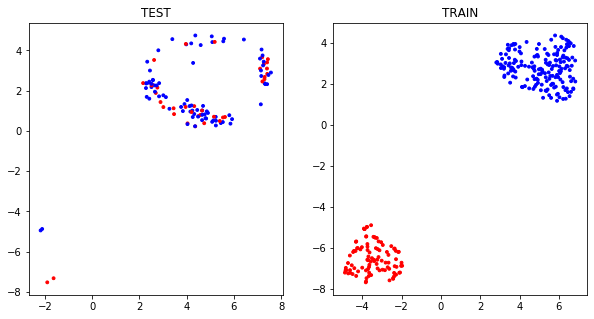

In [169]:
plot_embedding(res_m3_test,labels_test,res_m3_train,labels_train)

# MODEL4: Vect -- PCA_500 -- SUPERVISED_AUTOENCODER_60 -- UMAP 2
## 2 ITERATIONS
### with my_callback

In [171]:
pca_4 = TruncatedSVD(n_components=500)
m4_200_data_train = pca_4.fit(data_train).transform(data_train)
m4_200_data_test = pca_4.transform(data_test)

# SCALER
scaler_4 = Preprocessing_scaler([0, 1])
m4_200_scal_data_train = scaler_4.fit(m4_200_data_train).transform(m4_200_data_train)
m4_200_scal_data_test = scaler_4.transform(m4_200_data_test)

# NORMALIZER
normalizer_4 = Normalizer(copy=True, norm='l2')  
m4_200_norm_data_train = normalizer_4.fit(m4_200_scal_data_train).transform(m4_200_scal_data_train)
m4_200_norm_data_test = normalizer_4.transform(m4_200_scal_data_test)

input_auto = len(m2_200_scal_data_train[0])

In [172]:
# define model 1

iniz = RandomNormal(mean=0, stddev=0.05)

prob_drop = 0.5
x_in = Input(shape=(input_auto,))
enc = Dense(input_auto*2, activation="relu",kernel_initializer=iniz)(x_in)
enc = Dropout(prob_drop)(enc)
enc = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)
enc = Dense(60, activation="sigmoid",kernel_initializer=iniz)(enc)

decode = Dense(input_auto, activation="relu",name='decoder',kernel_initializer=iniz)(enc)

cla = Dense(10, activation='relu',name='cla_10')(enc)
cla = Dense(2, activation='softmax',name='classifier')(cla)


sup_autoencoder_2 = Model(inputs = x_in, outputs = [decode,cla])

sup_autoencoder_2.compile(optimizer='adam',
                            metrics={'decoder': 'mse', 'classifier': ['acc']},
                            loss = {'decoder': 'mean_squared_error', 'classifier': 'categorical_crossentropy'},
                            loss_weights = {'decoder': 0.1, 'classifier': 0.00001})

In [173]:
# train model 1
path = "logs_sintetici/sintetici_mix_1_20050077769"
tb = TensorBoard(log_dir=path)
er = EarlyStopping(monitor='val_classifier_acc', patience=100, restore_best_weights=True)

sup_autoencoder_2.fit(m4_200_norm_data_train,
                    {'decoder': m4_200_norm_data_train, 'classifier': utilities.from_np_to_one_hot(labels_train)},
                    epochs=500,    
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[tb,er])

a = sup_autoencoder_2.evaluate(m4_200_norm_data_test,[m4_200_norm_data_test,utilities.from_np_to_one_hot(labels_test)])
n = sup_autoencoder_2.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

118/118 [==============================] - 0s 313us/step
loss 0.00034013953182246475
decoder_loss 0.003339070783359772
classifier_loss 0.6232453180571734
decoder_mean_squared_error 0.003339070783359772
classifier_acc 0.6864406769558534


In [174]:
#### get weights
autoencoder_2_w = sup_autoencoder_2.get_weights()

### model 2
### variable parameter tensorflow

In [175]:
from keras import backend as K

w_dec = K.variable(1)
w_cla = K.variable(0.1)

In [176]:
# model 2
iniz = RandomNormal(mean=0, stddev=0.05)

prob_drop = 0.5

x_in = Input(shape=(input_auto,))
enc = Dense(input_auto*2, activation="relu",kernel_initializer=iniz)(x_in)
enc = Dropout(prob_drop)(enc)
enc = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)
enc = Dense(60, activation="sigmoid",kernel_initializer=iniz)(enc)

decode = Dense(input_auto, activation="relu",name='decoder',kernel_initializer=iniz)(enc)

cla = Dense(10, activation='relu',trainable=False, name='cla_10')(enc)
cla = Dense(2, activation='softmax',trainable=False,name='classifier')(cla)


sup_autoencoder_2 = Model(inputs = x_in, outputs = [decode,cla])
sup_autoencoder_2.compile(optimizer='adam',
                            metrics={'decoder': 'mse', 'classifier': ['acc']},
                            loss = {'decoder': 'mean_squared_error', 'classifier': 'categorical_crossentropy'},
                            loss_weights = {'decoder': w_dec, 'classifier': w_cla})


In [177]:
sup_autoencoder_2.set_weights(autoencoder_2_w)

In [178]:
path = "logs_sintetici/test_callbacks1000000"
tb = TensorBoard(log_dir=path)

epochs = 500
my = MyCallback(w_dec,w_cla,epochs)


h = sup_autoencoder_2.fit(m4_200_norm_data_train,
                    {'decoder': m4_200_norm_data_train, 'classifier': utilities.from_np_to_one_hot(labels_train)},
                    epochs=epochs,    
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[tb,my])

a = sup_autoencoder_2.evaluate(m4_200_norm_data_test,[m4_200_norm_data_test,utilities.from_np_to_one_hot(labels_test)])
n = sup_autoencoder_2.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

118/118 [==============================] - 0s 256us/step
loss 0.012082545860212738
decoder_loss 0.0013862589386023454
classifier_loss 0.7900574752839945
decoder_mean_squared_error 0.0013862589386023454
classifier_acc 0.6355932152877419


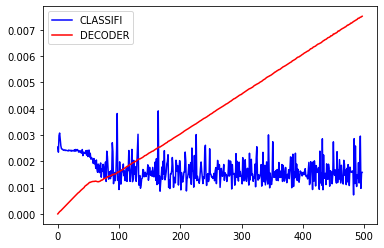

In [179]:
plot_loss(my,h)

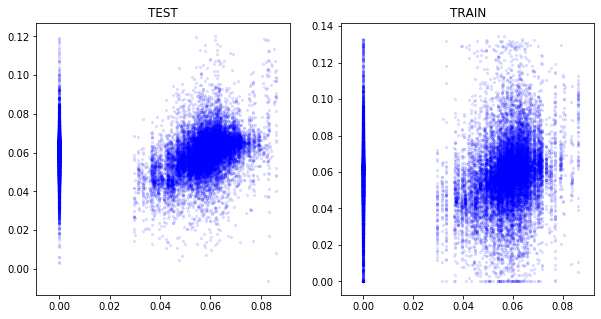

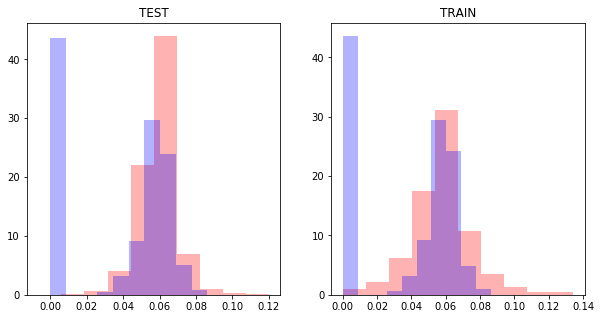

In [180]:
pred_test = sup_autoencoder_2.predict(m4_200_norm_data_test)[0]
pred_train = sup_autoencoder_2.predict(m4_200_norm_data_train)[0]


plot_auto(pred_test,pred_train,m4_200_norm_data_test,m4_200_norm_data_train)

# UMAP from 60 to 2

In [181]:
encoder_3 = Model(x_in, enc)
res_sup_auto_train = encoder_3.predict(m4_200_norm_data_train)

uma_4 = umap.UMAP(n_components=2)
res_m4_train = uma_4.fit(res_sup_auto_train,labels_train).transform(res_sup_auto_train)

res_sup_auto_test = encoder_3.predict(m4_200_norm_data_test)
res_m4_test = uma_4.transform(res_sup_auto_test)

/home/antonio/anaconda3/envs/tesi/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components



		 +++++ TEST +++++
K.N.N.  acc:  0.6101398601398602

		 +++++ TRAIN +++++
K.N.N.  acc:  1.0


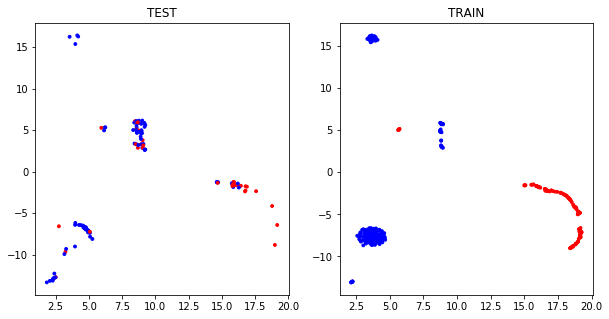

In [182]:
plot_embedding(res_m4_test,labels_test,res_m4_train,labels_train)

# MODEL5: Vect -- PCA_500 -- SUPERVISED_AUTOENCODER_60 -- UMAP 2
### with my_callback sinusoidal

In [191]:
pca_4 = TruncatedSVD(n_components=500)
m4_200_data_train = pca_4.fit(data_train).transform(data_train)
m4_200_data_test = pca_4.transform(data_test)

# SCALER
scaler_4 = Preprocessing_scaler([0, 1])
m4_200_scal_data_train = scaler_4.fit(m4_200_data_train).transform(m4_200_data_train)
m4_200_scal_data_test = scaler_4.transform(m4_200_data_test)

# NORMALIZER
normalizer_4 = Normalizer(copy=True, norm='l2')  
m4_200_norm_data_train = normalizer_4.fit(m4_200_scal_data_train).transform(m4_200_scal_data_train)
m4_200_norm_data_test = normalizer_4.transform(m4_200_scal_data_test)

input_auto = len(m2_200_scal_data_train[0])

In [199]:
iniz = RandomNormal(mean=0, stddev=0.05)
w_dec = K.variable(1)
w_cla = K.variable(0.1)


prob_drop = 0.5
x_in = Input(shape=(input_auto,))
enc = Dense(input_auto*2, activation="relu",kernel_initializer=iniz)(x_in)
enc = Dropout(prob_drop)(enc)
enc = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)
enc = Dense(60, activation="sigmoid",kernel_initializer=iniz)(enc)

decode = Dense(input_auto, activation="relu",name='decoder',kernel_initializer=iniz)(enc)

cla = Dense(10, activation='relu', name='cla_10')(enc)
cla = Dense(2, activation='softmax',name='classifier')(cla)


sup_autoencoder = Model(inputs = x_in, outputs = [decode,cla])
sup_autoencoder.compile(optimizer='adam',
                            metrics={'decoder': 'mse', 'classifier': ['acc']},
                            loss = {'decoder': 'mean_squared_error', 'classifier': 'categorical_crossentropy'},
                            loss_weights = {'decoder': w_dec, 'classifier': w_cla})

In [200]:
path = "logs_sintetici/test_PROVA_700"
tb = TensorBoard(log_dir=path)

epochs = 1000
my = MyCallback_sinusoidal(w_dec = w_dec,
                           w_cla = w_cla,
                           n_epoch = epochs,
                           n_period = 4,
                           scal_c = 100,
                           scal_d = 5)

# 4 - 50 - 5
h = sup_autoencoder.fit(m4_200_norm_data_train,
                    {'decoder': m4_200_norm_data_train, 'classifier': utilities.from_np_to_one_hot(labels_train)},
                    epochs=epochs,    
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[tb,my])

a = sup_autoencoder.evaluate(m4_200_norm_data_test,[m4_200_norm_data_test,utilities.from_np_to_one_hot(labels_test)])
n = sup_autoencoder.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

118/118 [==============================] - 0s 239us/step
loss 0.0071351016887416276
decoder_loss 0.0017571353661369974
classifier_loss 0.6684203764139596
decoder_mean_squared_error 0.0017571353661369974
classifier_acc 0.6525423769223488


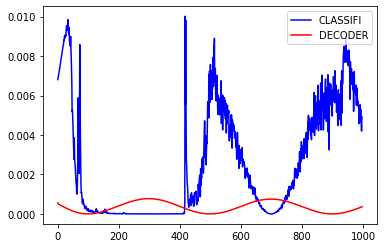

In [201]:
plot_loss(my,h)

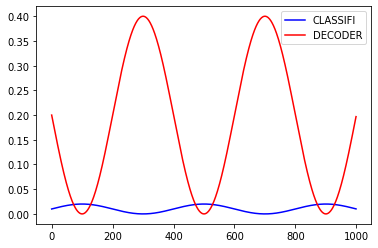

In [202]:
plt.plot(my.w_cals,label="CLASSIFI",c = 'b')
plt.plot(my.w_decs,label="DECODER", c="r")
plt.legend()

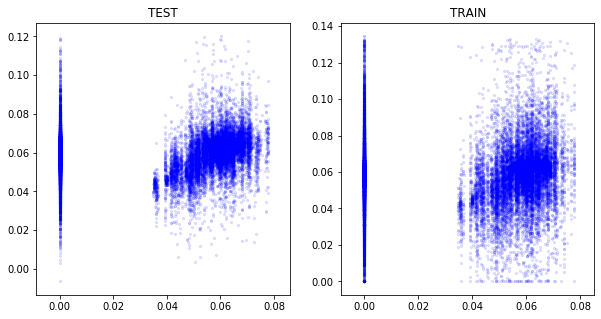

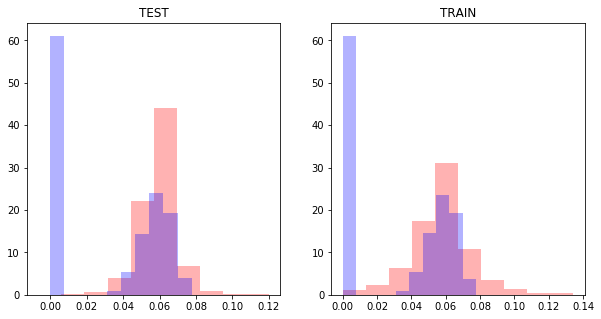

In [203]:
pred_test = sup_autoencoder.predict(m4_200_norm_data_test)[0]
pred_train = sup_autoencoder.predict(m4_200_norm_data_train)[0]

plot_auto(pred_test,pred_train,m4_200_norm_data_test,m4_200_norm_data_train)

# UMAP from 60 to 2

In [209]:
encoder_3 = Model(x_in, enc)
res_sup_auto_train = encoder_3.predict(m4_200_norm_data_train)

uma_4 = umap.UMAP(n_components=2)
res_m4_train = uma_4.fit(res_sup_auto_train,labels_train).transform(res_sup_auto_train)

res_sup_auto_test = encoder_3.predict(m4_200_norm_data_test)
res_m4_test = uma_4.transform(res_sup_auto_test)

/home/antonio/anaconda3/envs/tesi/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components



		 +++++ TEST +++++
K.N.N.  acc:  0.6798368298368299

		 +++++ TRAIN +++++
K.N.N.  acc:  0.9567358567358568


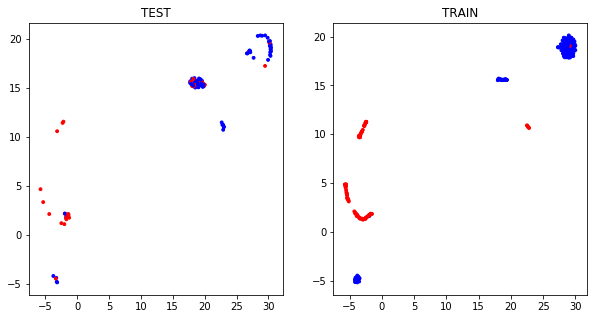

In [210]:
plot_embedding(res_m4_test,labels_test,res_m4_train,labels_train)

In [56]:
import keras.backend.tensorflow_backend as K
from keras import callbacks
import math

class MyCallback_sinusoidal(callbacks.Callback):
    def __init__(self, w_dec, w_cla, n_epoch,n_period,scal_c,scal_d):
        
        self.n_epoch = n_epoch
        self.w_dec = w_dec
        self.w_cla = w_cla
        
        self.w_cals = []
        self.w_decs = []
        
        
        
        samples_s = np.linspace(-(math.pi), n_period*(math.pi),n_epoch+1)
        

        s = np.sin(samples_s)
        c = -s
        s = s + 1
        c = c + 1

        s = s/scal_d
        c = c/scal_c        
        
        self.sin = s
        self.cos = c

        
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.w_cla, self.cos[epoch])
        K.set_value(self.w_dec, self.sin[epoch])

            
        self.w_decs.append(K.get_value(self.w_dec))
        self.w_cals.append(K.get_value(self.w_cla))

In [60]:
def plot_loss(my,h):
    clas = my.w_cals
    clal = h.history['classifier_loss']

    dec = my.w_decs
    decl = h.history['decoder_loss']

    c = []
    d = []

    for i in range(len(dec)):
        c.append(clas[i]*clal[i])
        d.append(dec[i]*decl[i])

    plt.plot(c[1:-1],label="CLASSIFI",c = 'b')
    plt.plot(d[1:-1],label="DECODER", c="r")
    plt.legend()
    plt.show()

In [14]:
from keras import callbacks

class MyCallback(callbacks.Callback):
    def __init__(self, w_dec, w_cla, n_epoch):
        
        self.n_epoch = n_epoch
        self.w_dec = w_dec
        self.w_cla = w_cla
        self.w_cals = []
        self.w_decs = []
    # customize your behavior
        
    def on_epoch_end(self, epoch, logs={}):
        
        
        cla = logs['classifier_loss']
        dec = logs['decoder_loss']
        # redi uguale il peso delle 2 loss
        tmp = dec/cla
        
        # dai piu peso al decoder al crescere delle epoche
        new_dec = 5*epoch / (self.n_epoch) 
        
        self.w_decs.append(K.get_value(self.w_dec))
        self.w_cals.append(K.get_value(self.w_cla))
        
        K.set_value(self.w_cla, tmp)
        K.set_value(self.w_dec, new_dec)

In [15]:
def plot_embedding(res_test,labels_test,res_train,labels_train):

    colors = ['red','blue']
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    x = res_test[:,0]
    y = res_test[:,1]
    plt.title("TEST")
    plt.scatter(x,y,s=8,c=labels_test,cmap=matplotlib.colors.ListedColormap(colors))


    plt.subplot(122)
    x = res_train[:,0]
    y = res_train[:,1]
    plt.title("TRAIN")
    plt.scatter(x,y,s=8,c=labels_train,cmap=matplotlib.colors.ListedColormap(colors))


    print("\n\t\t +++++ TEST +++++")
    eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
    acc, pre, rec, f = eva.performance_with_kfold(res_test,labels_test)
    print("K.N.N.  acc: ",np.mean(acc))
    
    print("\n\t\t +++++ TRAIN +++++")
    eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
    acc, pre, rec, f = eva.performance_with_kfold(res_train,labels_train)
    print("K.N.N.  acc: ",np.mean(acc))

In [16]:


def plot_auto(pred_test,pred_train,data_test,data_train):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("TEST")
    for i in range(0,100):
        a = pred_test[i]
        b = data_test[i]
        plt.scatter(a,b,s=5,c='b',alpha=0.1)

    plt.subplot(122)
    plt.title("TRAIN")
    for i in range(0,100):
        a = pred_train[i]
        b = data_train[i]
        plt.scatter(a,b,s=5,c='b',alpha=0.1)
        

    tmp = []

    for a in data_test:
        for b in a:
            tmp.append(b)

    tmp_2 = []
    for a in pred_test:
        for b in a:
            tmp_2.append(b)

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("TEST")
    plt.hist(tmp,alpha=0.3,color='red',bins=10,density=True)
    plt.hist(tmp_2,alpha=0.3,color='blue', bins=10,density=True)
    tmp = []

    for a in data_train:
        for b in a:
            tmp.append(b)

    tmp_2 = []
    for a in pred_train:
        for b in a:
            tmp_2.append(b)

    plt.subplot(122)
    plt.title("TRAIN")
    plt.hist(tmp,alpha=0.3,color='red',bins=10,density=True)
    plt.hist(tmp_2,alpha=0.3,color='blue', bins=10,density=True)

    plt.show()


